# Segmentation and Analysis of Berlin's neighborhoods

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.cluster import KMeans
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import matplotlib.pyplot as plt

### Data preparation and cleaning
After importing all necessary libraries we will load the csv-file with Berlin's population data, divided by postal code area to a dataframa

In [2]:
df_berlin = pd.read_csv('Berlin_data.csv')
df_berlin

PostalCode          Neighborhood Citizens under6  6to15 15to18 18to27  \
0         10115                 Mitte   27 195  1 870  2 189    538  2 421   
1         10117                 Mitte   16 180    944    900    255  1 535   
2         10119                 Mitte   15 263    972  1 137    243  1 225   
3         10119                Pankow    4 685    290    435    117    470   
4         10178  Friedrichsh.-Kreuzb.       69      3      6      –      6   
..          ...                   ...      ...    ...    ...    ...    ...   
232       14195     Steglitz-Zehlend.   15 701    779  1 554    590  1 509   
233       14197    Charlbg.-Wilmersd.   18 090    783  1 126    397  1 459   
234       14197     Steglitz-Zehlend.      399     15     37     13     27   
235       14197     Tempelh.-Schöneb.    1 355     66     84     24    167   
236       14199    Charlbg.-Wilmersd.   15 695    750  1 200    309  1 316   

     27to45 45to55  5to65 above65  female  
0    11 769  4 369  2 300   1 739  13 339  
1     5 632  2 371  1 903   2 640   7 787  
2     6 783  2 582  1 207   1 114   7 519  
3     1 744    986    426     217   2 266  
4        20     12      –      22      35  
..      ...    ...    ...     ...     ...  
232   2 681  2 480  2 098   4 010   8 188  
233   3 744  2 636  2 739   5 206   9 761  
234      83     64     61      99     214  
235     377    169    186     282     678  
236   3 063  2 344  2 124   4 589   8 390  

[237 rows x 12 columns]

And then do some data wrangling: remove empty space between the digits in column Citizens; remove incomplete data (column Citizens has value '-' for some rows) 

In [3]:
# Remove empty space between the digits in column Citizens
df_berlin['Citizens'] = df_berlin['Citizens'].str.replace(' ', '')

# Get names of indexes for which column Citizens has value '-'
indexNames = df_berlin[df_berlin['Citizens'].str.match('–')].index
# Delete these row indexes from dataFrame Berlin
df_berlin.drop(indexNames, inplace=True)

# Change data type of column Citizens to Integer
df_berlin['Citizens'] = pd.to_numeric(df_berlin['Citizens'])
df_berlin.dtypes

PostalCode       int64
Neighborhood    object
Citizens         int64
under6          object
6to15           object
15to18          object
18to27          object
27to45          object
45to55          object
5to65           object
above65         object
female          object
dtype: object

In [4]:
# Change data type of column PostalCode to String
df_berlin['PostalCode'] = df_berlin['PostalCode'].apply(str)

# Due to Foursquare limitations, I have deicided to segment and cluster only the neighborhoods in central Berlin
# Therefore let us slice the original data frame and then create new one containing only Postal Codes starting with 10xxx 
df_berlin_new = df_berlin[df_berlin['PostalCode'].str.match('10')]
df_berlin_new

PostalCode          Neighborhood  Citizens under6  6to15 15to18 18to27  \
0       10115                 Mitte     27195  1 870  2 189    538  2 421   
1       10117                 Mitte     16180    944    900    255  1 535   
2       10119                 Mitte     15263    972  1 137    243  1 225   
3       10119                Pankow      4685    290    435    117    470   
4       10178  Friedrichsh.-Kreuzb.        69      3      6      –      6   
..        ...                   ...       ...    ...    ...    ...    ...   
74      10967              Neukölln      2137    149    157     40    191   
75      10969  Friedrichsh.-Kreuzb.     28164  1 902  2 932    917  3 524   
76      10969                 Mitte         6      –      3      –      –   
77      10997  Friedrichsh.-Kreuzb.     26569  1 488  1 893    584  2 820   
78      10999  Friedrichsh.-Kreuzb.     26052  1 414  1 854    662  2 753   

    27to45 45to55  5to65 above65  female  
0   11 769  4 369  2 300   1 739  13 339  
1    5 632  2 371  1 903   2 640   7 787  
2    6 783  2 582  1 207   1 114   7 519  
3    1 744    986    426     217   2 266  
4       20     12      –      22      35  
..     ...    ...    ...     ...     ...  
74     841    276    277     206   1 033  
75   8 204  3 942  3 006   3 737  13 950  
76       –      3      –       –       3  
77  10 185  3 969  3 092   2 538  12 733  
78   9 822  3 914  2 985   2 648  12 590  

[79 rows x 12 columns]

In [5]:
# Change data type of column PostalCode to String
df_berlin['PostalCode'] = df_berlin['PostalCode'].apply(str)
df_berlin.dtypes

PostalCode      object
Neighborhood    object
Citizens         int64
under6          object
6to15           object
15to18          object
18to27          object
27to45          object
45to55          object
5to65           object
above65         object
female          object
dtype: object

Next step will be to load the csv-file with Berlin's tourist data, divided by district (Bezirk) to a dataframe, followed by short data cleaning

In [6]:
df_berlin_tourist = pd.read_csv('Berlin_tourist_2019.csv')
df_berlin_tourist

Neighborhood GuestsNumber OversleepsCount  AverageDaysStay
0                        Mitte    4 514 797      11 093 845              2.5
1     Friedrichshain-Kreuzberg    1 364 510       3 545 813              2.6
2                       Pankow      390 196       1 079 641              2.8
3   Charlottenburg-Wilmersdorf    2 015 172       4 843 851              2.4
4                      Spandau      206 739         463 557              2.2
5          Steglitz-Zehlendorf      160 011         383 326              2.4
6         Tempelhof-Schöneberg      623 744       1 587 317              2.5
7                     Neukölln      304 844         697 447              2.3
8             Treptow-Köpenick      230 442         509 715              2.2
9          Marzahn-Hellersdorf       70 036         200 963              2.9
10                 Lichtenberg      389 043         960 844              2.5
11               Reinickendorf      168 641         390 203              2.3

In [7]:
#remove empty spaces
df_berlin_tourist['GuestsNumber'] = df_berlin_tourist['GuestsNumber'].str.replace(' ', '')
df_berlin_tourist['OversleepsCount'] = df_berlin_tourist['OversleepsCount'].str.replace(' ', '')
df_berlin_tourist

Neighborhood GuestsNumber OversleepsCount  AverageDaysStay
0                        Mitte      4514797        11093845              2.5
1     Friedrichshain-Kreuzberg      1364510         3545813              2.6
2                       Pankow       390196         1079641              2.8
3   Charlottenburg-Wilmersdorf      2015172         4843851              2.4
4                      Spandau       206739          463557              2.2
5          Steglitz-Zehlendorf       160011          383326              2.4
6         Tempelhof-Schöneberg       623744         1587317              2.5
7                     Neukölln       304844          697447              2.3
8             Treptow-Köpenick       230442          509715              2.2
9          Marzahn-Hellersdorf        70036          200963              2.9
10                 Lichtenberg       389043          960844              2.5
11               Reinickendorf       168641          390203              2.3

In [8]:
# Change data type of column GuestsNumber to Integer
df_berlin_tourist['GuestsNumber'] = pd.to_numeric(df_berlin_tourist['GuestsNumber'])
df_berlin_tourist.dtypes

Neighborhood        object
GuestsNumber         int64
OversleepsCount     object
AverageDaysStay    float64
dtype: object

In [9]:
df_berlin_new['PostalCode'] = pd.to_numeric(df_berlin_new['PostalCode'])
df_berlin_new.dtypes

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


PostalCode       int64
Neighborhood    object
Citizens         int64
under6          object
6to15           object
15to18          object
18to27          object
27to45          object
45to55          object
5to65           object
above65         object
female          object
dtype: object

In [10]:
# Load coordinate data from CSV file
df_coordinates = pd.read_csv('berlin_geocoordinates.csv')
# Raname column 'Postleitzahl' extacted from the csv file to 'PostalCode' so that both dataframes have the same column name
df_coordinates = df_coordinates.rename({'Postleitzahl':'PostalCode'}, axis=1)
# Merge coordinates into Berlin neighbourhoods dataframe
df_berlin_new = df_berlin_new.merge(df_coordinates)
df_berlin_new.head(5)

PostalCode          Neighborhood  Citizens under6  6to15 15to18 18to27  \
0       10115                 Mitte     27195  1 870  2 189    538  2 421   
1       10117                 Mitte     16180    944    900    255  1 535   
2       10119                 Mitte     15263    972  1 137    243  1 225   
3       10119                Pankow      4685    290    435    117    470   
4       10178  Friedrichsh.-Kreuzb.        69      3      6      –      6   

   27to45 45to55  5to65 above65  female   Latitude  Longitude      Ortsname  
0  11 769  4 369  2 300   1 739  13 339  52.532139  13.384672  Berlin Mitte  
1   5 632  2 371  1 903   2 640   7 787  52.516882  13.387370  Berlin Mitte  
2   6 783  2 582  1 207   1 114   7 519  52.530477  13.405328  Berlin Mitte  
3   1 744    986    426     217   2 266  52.530477  13.405328  Berlin Mitte  
4      20     12      –      22      35  52.521310  13.409805  Berlin Mitte

## Explore and cluster the neighborhoods in Berlin

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'X2QQIMI5GCZVR2JNG1TV5HMAJQH2DFSOXPH4NGHFUEEJQUOO' # my Foursquare ID
CLIENT_SECRET = 'N2PO3UKJFRUF5HJT4QZFDCTHG4TDSIVDNUWESWNRWATR0QFK' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100

Your credentails:
CLIENT_ID: X2QQIMI5GCZVR2JNG1TV5HMAJQH2DFSOXPH4NGHFUEEJQUOO
CLIENT_SECRET:N2PO3UKJFRUF5HJT4QZFDCTHG4TDSIVDNUWESWNRWATR0QFK


### And now let us explore the neighborhoods in Berlin

In [12]:
#this function is finding neraby venues (in radius of 300 m)
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Using the above function we create dataframe called *berlin_venues*

In [13]:
berlin_venues = getNearbyVenues(names=df_berlin_new['Neighborhood'],
                                   latitudes=df_berlin_new['Latitude'],
                                   longitudes=df_berlin_new['Longitude']
                                  )

Mitte
Mitte
Mitte
Pankow
Friedrichsh.-Kreuzb.
Mitte
Friedrichsh.-Kreuzb.
Mitte
Friedrichsh.-Kreuzb.
Friedrichsh.-Kreuzb.
Friedrichsh.-Kreuzb.
Pankow
Friedrichsh.-Kreuzb.
Pankow
Lichtenberg
Lichtenberg
Lichtenberg
Lichtenberg
Lichtenberg
Lichtenberg
Lichtenberg
Pankow
Pankow
Pankow
Mitte
Pankow
Pankow
Pankow
Mitte
Mitte
Mitte
Mitte
Mitte
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Mitte
Mitte
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Charlbg.-Wilmersd.
Tempelh.-Schöneb.
Charlbg.-Wilmersd.
Tempelh.-Schöneb.
Tempelh.-Schöneb.
Tempelh.-Schöneb.
Friedrichsh.-Kreuzb.
Mitte
Tempelh.-Schöneb.
Charlbg.-Wilmersd.
Mitte
Tempelh.-Schöneb.
Charlbg.-Wilmersd.
Tempelh.-Schöneb.
Tempelh.-Schöneb.
Charlbg.-Wilmersd.
Tempelh.-Schöneb.
Tempelh.-Schöneb.
Tempelh.-Schöneb.
Friedrichsh.-Kreuzb.
Friedrichsh.-Kreu

In [14]:
#Let's check the size of the resulting dataframe
print(berlin_venues.shape)
berlin_venues.head()

(1733, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Mitte              52.532139               13.384672   
1        Mitte              52.532139               13.384672   
2        Mitte              52.532139               13.384672   
3        Mitte              52.532139               13.384672   
4        Mitte              52.532139               13.384672   

                           Venue  Venue Latitude  Venue Longitude  \
0                      Hotel i31       52.531107        13.384270   
1                  Oslo Kaffebar       52.531029        13.386889   
2                     BeachMitte       52.533821        13.384628   
3  Brasserie La Bonne Franquette       52.531102        13.382489   
4             Kunstfabrik Schlot       52.530325        13.385230   

     Venue Category  
0             Hotel  
1       Coffee Shop  
2  Volleyball Court  
3         Brasserie  
4         Jazz Club

In [15]:
#Let's check how many venues were returned for each neighborhood
berlin_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                 
Charlbg.-Wilmersd.                      412                     412    412   
Friedrichsh.-Kreuzb.                    326                     326    326   
Lichtenberg                              40                      40     40   
Mitte                                   425                     425    425   
Neukölln                                 39                      39     39   
Pankow                                  246                     246    246   
Tempelh.-Schöneb.                       245                     245    245   

                      Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                           
Charlbg.-Wilmersd.               412              412             412  
Friedrichsh.-Kreuzb.             326              326             326  
Lichtenberg                       40               40              40  
Mitte                            425              425             425  
Neukölln                          39               39              39  
Pankow                           246              246             246  
Tempelh.-Schöneb.                245              245             245

And let us visualize the result: number of venues in each district (Bezirk) by grouping the venues, creating dataframe df_berlin_venues and then plotting column Neighborhood versus Venue: 

In [16]:
df_berlin_venues = berlin_venues.groupby('Neighborhood').count()
df_berlin_venues = df_berlin_venues.drop(df_berlin_venues.columns[[0,1,3,4,5]], axis=1)
df_berlin_venues.head()

Venue
Neighborhood               
Charlbg.-Wilmersd.      412
Friedrichsh.-Kreuzb.    326
Lichtenberg              40
Mitte                   425
Neukölln                 39

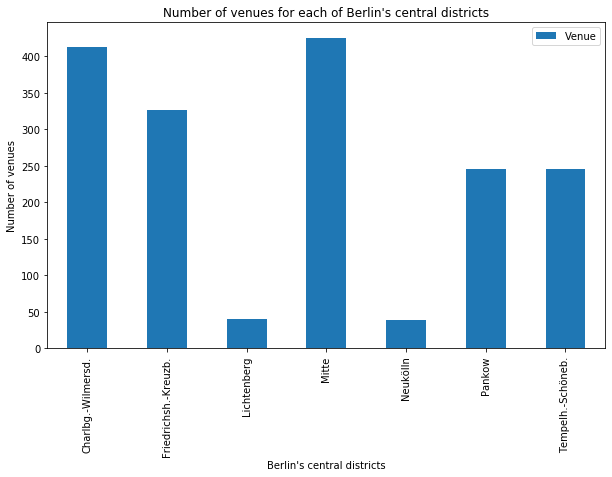

In [17]:
df_berlin_venues.plot(kind='bar', figsize=(10, 6))

plt.xlabel("Berlin's central districts") # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title("Number of venues for each of Berlin's central districts") # add title to the plot

plt.show()

#### We can clearly see that Berlin Mitte and Charlottenburg have the majority of venues, while Lichtenburg and Neukölln have the fewest.

#### Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 229 uniques categories.


## Analyze Each Neighborhood

In [19]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = berlin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

Neighborhood  ATM  Adult Boutique  African Restaurant  American Restaurant  \
0        Mitte    0               0                   0                    0   
1        Mitte    0               0                   0                    0   
2        Mitte    0               0                   0                    0   
3        Mitte    0               0                   0                    0   
4        Mitte    0               0                   0                    0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  ...  Vacation Rental  Vegetarian / Vegan Restaurant  \
0                 0  ...                0                              0   
1                 0  ...                0                              0   
2                 0  ...                0                              0   
3                 0  ...                0                              0   
4                 0  ...                0                              0   

   Video Store  Vietnamese Restaurant  Volleyball Court  Whisky Bar  Wine Bar  \
0            0                      0                 0           0         0   
1            0                      0                 0           0         0   
2            0                      0                 1           0         0   
3            0                      0                 0           0         0   
4            0                      0                 0           0         0   

   Wine Shop  Yoga Studio  Zoo Exhibit  
0          0            0            0  
1          0            0            0  
2          0            0            0  
3          0            0            0  
4          0            0            0  

[5 rows x 230 columns]

In [20]:
berlin_onehot.shape

(1733, 230)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped

Neighborhood       ATM  Adult Boutique  African Restaurant  \
0    Charlbg.-Wilmersd.  0.007282        0.000000            0.002427   
1  Friedrichsh.-Kreuzb.  0.000000        0.000000            0.006135   
2           Lichtenberg  0.000000        0.000000            0.000000   
3                 Mitte  0.000000        0.000000            0.000000   
4              Neukölln  0.000000        0.000000            0.000000   
5                Pankow  0.000000        0.004065            0.000000   
6     Tempelh.-Schöneb.  0.004082        0.000000            0.004082   

   American Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0             0.002427                0.002427     0.000000    0.000000   
1             0.003067                0.000000     0.006135    0.012270   
2             0.000000                0.000000     0.000000    0.000000   
3             0.004706                0.000000     0.004706    0.009412   
4             0.000000                0.000000     0.000000    0.000000   
5             0.008130                0.000000     0.004065    0.000000   
6             0.000000                0.000000     0.000000    0.012245   

   Arts & Crafts Store  Asian Restaurant  ...  Vacation Rental  \
0             0.002427          0.007282  ...         0.000000   
1             0.000000          0.018405  ...         0.000000   
2             0.000000          0.025000  ...         0.000000   
3             0.002353          0.009412  ...         0.004706   
4             0.000000          0.051282  ...         0.000000   
5             0.004065          0.012195  ...         0.004065   
6             0.000000          0.004082  ...         0.000000   

   Vegetarian / Vegan Restaurant  Video Store  Vietnamese Restaurant  \
0                       0.004854     0.002427               0.024272   
1                       0.006135     0.006135               0.030675   
2                       0.000000     0.000000               0.000000   
3                       0.009412     0.000000               0.014118   
4                       0.025641     0.025641               0.051282   
5                       0.016260     0.004065               0.028455   
6                       0.008163     0.004082               0.024490   

   Volleyball Court  Whisky Bar  Wine Bar  Wine Shop  Yoga Studio  Zoo Exhibit  
0          0.000000    0.002427  0.007282   0.002427     0.002427     0.014563  
1          0.000000    0.000000  0.003067   0.003067     0.000000     0.000000  
2          0.000000    0.000000  0.000000   0.000000     0.000000     0.000000  
3          0.002353    0.000000  0.007059   0.002353     0.002353     0.014118  
4          0.000000    0.000000  0.025641   0.000000     0.000000     0.000000  
5          0.000000    0.000000  0.012195   0.004065     0.000000     0.000000  
6          0.000000    0.000000  0.008163   0.004082     0.000000     0.024490  

[7 rows x 230 columns]

#### Let's print each neighborhood along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in berlin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Charlbg.-Wilmersd.----
                venue  freq
0  Italian Restaurant  0.08
1               Hotel  0.07
2                Café  0.07
3         Supermarket  0.04
4   German Restaurant  0.03


----Friedrichsh.-Kreuzb.----
                venue  freq
0                 Bar  0.06
1                Café  0.05
2  Italian Restaurant  0.04
3   German Restaurant  0.03
4               Hotel  0.03


----Lichtenberg----
                venue  freq
0         Supermarket  0.15
1           Drugstore  0.10
2        Tram Station  0.08
3               Plaza  0.05
4  Italian Restaurant  0.05


----Mitte----
                venue  freq
0               Hotel  0.07
1  Italian Restaurant  0.06
2                Café  0.06
3   German Restaurant  0.04
4         Coffee Shop  0.03


----Neukölln----
                   venue  freq
0                   Café  0.10
1     Italian Restaurant  0.08
2            Music Venue  0.05
3  Vietnamese Restaurant  0.05
4       Asian Restaurant  0.05


----Pankow----
          

In [23]:
#this function will sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### And now we can create new dataframe and display the top 5 venues for each neighborhood

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0    Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
1  Friedrichsh.-Kreuzb.                   Bar                  Café   
2           Lichtenberg           Supermarket             Drugstore   
3                 Mitte                 Hotel                  Café   
4              Neukölln                  Café    Italian Restaurant   
5                Pankow                  Café                Bakery   
6     Tempelh.-Schöneb.                  Café                 Hotel   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
0                  Café            Supermarket                Bakery  
1    Italian Restaurant  Vietnamese Restaurant                 Hotel  
2          Tram Station          Shopping Mall          Soccer Field  
3    Italian Restaurant      German Restaurant           Coffee Shop  
4    Chinese Restaurant  Vietnamese Restaurant      Asian Restaurant  
5                   Bar     Italian Restaurant                 Hotel  
6    Italian Restaurant            Supermarket           Zoo Exhibit

## Cluster Neighborhoods of Berlin with K-Means Clustering Algorithm

#### First step is to determine value for K using the ELbow Method

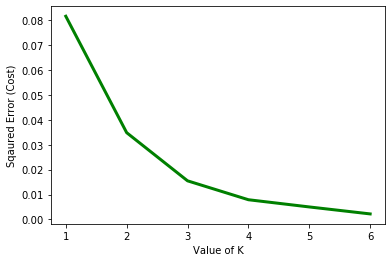

In [25]:
cost =[] 
berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

for i in range(1, 7): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(berlin_grouped_clustering)       
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1,7), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

#### The figure above shows the result of plotting the Sum of Squared Error versus different K Values and for K - value equals to 4 to error starts to diminish. That is why I will K = 4 for the K-Means clustering algorithm.

In [26]:
# set number of clusters
kclusters = 4
berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 2, 3, 0, 1, 3], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
berlin_merged=df_berlin_new
# merge berlin venues with berlin data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

berlin_merged.head(10)

PostalCode          Neighborhood  Citizens under6  6to15 15to18 18to27  \
0       10115                 Mitte     27195  1 870  2 189    538  2 421   
1       10117                 Mitte     16180    944    900    255  1 535   
2       10119                 Mitte     15263    972  1 137    243  1 225   
3       10119                Pankow      4685    290    435    117    470   
4       10178  Friedrichsh.-Kreuzb.        69      3      6      –      6   
5       10178                 Mitte     14520    749    776    184  1 604   
6       10179  Friedrichsh.-Kreuzb.       419     31     25      6     15   
7       10179                 Mitte     24585  1 337  1 275    340  2 753   
8       10243  Friedrichsh.-Kreuzb.     31813  1 838  1 854    455  3 708   
9       10245  Friedrichsh.-Kreuzb.     35355  2 592  2 061    473  3 593   

   27to45 45to55  5to65  ...  female   Latitude  Longitude  \
0  11 769  4 369  2 300  ...  13 339  52.532139  13.384672   
1   5 632  2 371  1 903  ...   7 787  52.516882  13.387370   
2   6 783  2 582  1 207  ...   7 519  52.530477  13.405328   
3   1 744    986    426  ...   2 266  52.530477  13.405328   
4      20     12      –  ...      35  52.521310  13.409805   
5   5 208  1 810  1 513  ...   7 032  52.521310  13.409805   
6     124     40     47  ...     234  52.512113  13.416405   
7   8 246  2 952  2 698  ...  12 236  52.512113  13.416405   
8  12 643  3 531  2 930  ...  15 695  52.512276  13.439405   
9  18 338  4 328  2 141  ...  16 809  52.500643  13.464747   

                Ortsname Cluster Labels  1st Most Common Venue  \
0           Berlin Mitte              3                  Hotel   
1           Berlin Mitte              3                  Hotel   
2           Berlin Mitte              3                  Hotel   
3           Berlin Mitte              1                   Café   
4           Berlin Mitte              1                    Bar   
5           Berlin Mitte              3                  Hotel   
6           Berlin Mitte              1                    Bar   
7           Berlin Mitte              3                  Hotel   
8  Berlin Friedrichshain              1                    Bar   
9  Berlin Friedrichshain              1                    Bar   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0                  Café    Italian Restaurant      German Restaurant   
1                  Café    Italian Restaurant      German Restaurant   
2                  Café    Italian Restaurant      German Restaurant   
3                Bakery                   Bar     Italian Restaurant   
4                  Café    Italian Restaurant  Vietnamese Restaurant   
5                  Café    Italian Restaurant      German Restaurant   
6                  Café    Italian Restaurant  Vietnamese Restaurant   
7                  Café    Italian Restaurant      German Restaurant   
8                  Café    Italian Restaurant  Vietnamese Restaurant   
9                  Café    Italian Restaurant  Vietnamese Restaurant   

  5th Most Common Venue  
0           Coffee Shop  
1           Coffee Shop  
2           Coffee Shop  
3                 Hotel  
4                 Hotel  
5           Coffee Shop  
6                 Hotel  
7           Coffee Shop  
8                 Hotel  
9                 Hotel  

[10 rows x 21 columns]

#### And now let us visualise the clustering using folium map

In [28]:
# create map
map_clusters = folium.Map(location=[52.525734, 13.401355], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### We can clearly see the partitioning of central Berlin in 4 clusters so now let us examine each cluster

#### Cluster 1:  most common venues are cafes, followed by Italian restaurants and Asian restaurants. This segment is attractive for food-tourists and food businesses

In [29]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[1] + list(range(15, berlin_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
73     Neukölln               0                  Café    Italian Restaurant   
76     Neukölln               0                  Café    Italian Restaurant   

   3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
73    Chinese Restaurant  Vietnamese Restaurant      Asian Restaurant  
76    Chinese Restaurant  Vietnamese Restaurant      Asian Restaurant

#### Cluster 2: most common venues are cafes and bars, followed by bakeries, restaurants, hotels. This segment of Berlin is connected with nightlife and social venues

In [30]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(16, berlin_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
3                 Pankow                  Café                Bakery   
4   Friedrichsh.-Kreuzb.                   Bar                  Café   
6   Friedrichsh.-Kreuzb.                   Bar                  Café   
8   Friedrichsh.-Kreuzb.                   Bar                  Café   
9   Friedrichsh.-Kreuzb.                   Bar                  Café   
10  Friedrichsh.-Kreuzb.                   Bar                  Café   
11                Pankow                  Café                Bakery   
12  Friedrichsh.-Kreuzb.                   Bar                  Café   
13                Pankow                  Café                Bakery   
21                Pankow                  Café                Bakery   
22                Pankow                  Café                Bakery   
23                Pankow                  Café                Bakery   
25                Pankow                  Café                Bakery   
26                Pankow                  Café                Bakery   
27                Pankow                  Café                Bakery   
56  Friedrichsh.-Kreuzb.                   Bar                  Café   
69  Friedrichsh.-Kreuzb.                   Bar                  Café   
70  Friedrichsh.-Kreuzb.                   Bar                  Café   
72  Friedrichsh.-Kreuzb.                   Bar                  Café   
75  Friedrichsh.-Kreuzb.                   Bar                  Café   
77  Friedrichsh.-Kreuzb.                   Bar                  Café   
79  Friedrichsh.-Kreuzb.                   Bar                  Café   
80  Friedrichsh.-Kreuzb.                   Bar                  Café   

   3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
3                    Bar     Italian Restaurant                 Hotel  
4     Italian Restaurant  Vietnamese Restaurant                 Hotel  
6     Italian Restaurant  Vietnamese Restaurant                 Hotel  
8     Italian Restaurant  Vietnamese Restaurant                 Hotel  
9     Italian Restaurant  Vietnamese Restaurant                 Hotel  
10    Italian Restaurant  Vietnamese Restaurant                 Hotel  
11                   Bar     Italian Restaurant                 Hotel  
12    Italian Restaurant  Vietnamese Restaurant                 Hotel  
13                   Bar     Italian Restaurant                 Hotel  
21                   Bar     Italian Restaurant                 Hotel  
22                   Bar     Italian Restaurant                 Hotel  
23                   Bar     Italian Restaurant                 Hotel  
25                   Bar     Italian Restaurant                 Hotel  
26                   Bar     Italian Restaurant                 Hotel  
27                   Bar     Italian Restaurant                 Hotel  
56    Italian Restaurant  Vietnamese Restaurant                 Hotel  
69    Italian Restaurant  Vietnamese Restaurant                 Hotel  
70    Italian Restaurant  Vietnamese Restaurant                 Hotel  
72    Italian Restaurant  Vietnamese Restaurant                 Hotel  
75    Italian Restaurant  Vietnamese Restaurant                 Hotel  
77    Italian Restaurant  Vietnamese Restaurant                 Hotel  
79    Italian Restaurant  Vietnamese Restaurant                 Hotel  
80    Italian Restaurant  Vietnamese Restaurant                 Hotel

#### Cluster 3: most common venues are Supermarket, Drugstores, Tram stations. Therefore this segment of Berlin is mostly residential.

In [31]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(16, berlin_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
14  Lichtenberg           Supermarket             Drugstore   
15  Lichtenberg           Supermarket             Drugstore   
16  Lichtenberg           Supermarket             Drugstore   
17  Lichtenberg           Supermarket             Drugstore   
18  Lichtenberg           Supermarket             Drugstore   
19  Lichtenberg           Supermarket             Drugstore   
20  Lichtenberg           Supermarket             Drugstore   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
14          Tram Station         Shopping Mall          Soccer Field  
15          Tram Station         Shopping Mall          Soccer Field  
16          Tram Station         Shopping Mall          Soccer Field  
17          Tram Station         Shopping Mall          Soccer Field  
18          Tram Station         Shopping Mall          Soccer Field  
19          Tram Station         Shopping Mall          Soccer Field  
20          Tram Station         Shopping Mall          Soccer Field

#### Cluster 4: most common venues are hotels, followed by cafes, restaurants, coffee shops. This part of Berlin is obviously the most attractive one for tourists.

In [32]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(16, berlin_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                Mitte                 Hotel                  Café   
1                Mitte                 Hotel                  Café   
2                Mitte                 Hotel                  Café   
5                Mitte                 Hotel                  Café   
7                Mitte                 Hotel                  Café   
24               Mitte                 Hotel                  Café   
28               Mitte                 Hotel                  Café   
29               Mitte                 Hotel                  Café   
30               Mitte                 Hotel                  Café   
31               Mitte                 Hotel                  Café   
32               Mitte                 Hotel                  Café   
33  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
34  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
35  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
36  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
37  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
38               Mitte                 Hotel                  Café   
39               Mitte                 Hotel                  Café   
40  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
41  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
42  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
43  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
44  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
45  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
46  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
47  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
48  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
49  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
50  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
51   Tempelh.-Schöneb.                  Café                 Hotel   
52  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
53   Tempelh.-Schöneb.                  Café                 Hotel   
54   Tempelh.-Schöneb.                  Café                 Hotel   
55   Tempelh.-Schöneb.                  Café                 Hotel   
57               Mitte                 Hotel                  Café   
58   Tempelh.-Schöneb.                  Café                 Hotel   
59  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
60               Mitte                 Hotel                  Café   
61   Tempelh.-Schöneb.                  Café                 Hotel   
62  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
63   Tempelh.-Schöneb.                  Café                 Hotel   
64   Tempelh.-Schöneb.                  Café                 Hotel   
65  Charlbg.-Wilmersd.    Italian Restaurant                 Hotel   
66   Tempelh.-Schöneb.                  Café                 Hotel   
67   Tempelh.-Schöneb.                  Café                 Hotel   
68   Tempelh.-Schöneb.                  Café                 Hotel   
71               Mitte                 Hotel                  Café   
74   Tempelh.-Schöneb.                  Café                 Hotel   
78               Mitte                 Hotel                  Café   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0     Italian Restaurant     German Restaurant           Coffee Shop  
1     Italian Restaurant     German Restaurant           Coffee Shop  
2     Italian Restaurant     German Restaurant           Coffee Shop  
5     Italian Restaurant     German Restaurant           Coffee Shop  
7     Italian Restaurant     German Restaurant           Coffee Shop  
24    Italian Restaurant     German Restaurant           Coffee Shop  
28    Italia

#### And now we want to visualise the segmentation combined with information about population density and number of tourist visotors, using Choropleth map.

In order to create `Choropleth` map, we need a GeoJSON file that defines the areas with own postal code and the boundaries of the city of Berlin that we are interested in. Such file is available online under https://data.technologiestiftung-berlin.de/dataset/plz/en Let us download it and name it berlin.json


In [33]:
# download Berlin postal codes geojson file
!wget --quiet https://tsb-opendata.s3.eu-central-1.amazonaws.com/plz/plz.geojson -O berlin_plz.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


Now that we have the GeoJSON file, let's create a Berlin map, centered around **[52.520008, 13.404954]** *latitude* and *longitude* values, with an intial zoom level of 11.

In [34]:
berlin_geo = r'berlin_plz.json' # geojson file

# create a plain Berlin map
berlin_map = folium.Map(location=[52.520008, 13.404954], zoom_start=11)

And now to create a `Choropleth` map, we will use the *choropleth* method with the following main parameters:

1. geo_data, which is the GeoJSON file.
2. data, which is the dataframe containing the data.
3. columns, which represents the columns in the dataframe that will be used to create the `Choropleth` map.
4. key_on, which is the key or variable in the GeoJSON file that contains the name of the variable of interest. To determine that, you will need to open the GeoJSON file using any text editor and note the name of the key or variable that contains the name of the countries, since the countries are our variable of interest. In this case, **name** is the key in the GeoJSON file that contains the name of the countries. Note that this key is case_sensitive, so you need to pass exactly as it exists in the GeoJSON file.

In [35]:
# create a numpy array of length 6 and has linear spacing from the minium Citizens numbers to the maximum 
threshold_scale = np.linspace(df_berlin['Citizens'].min(),
                              df_berlin['Citizens'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum im


# generate choropleth map using the total Berlin population
berlin_map.choropleth(
    geo_data=berlin_geo,
    data=df_berlin,
    columns=['PostalCode', 'Citizens'],
    key_on='feature.properties.spatial_name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Berlin population'
)

# instantiate a feature group for the clusters of Berlin
clusters = folium.map.FeatureGroup()

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    clusters.add_child(
      folium.CircleMarker(
        [lat, lon],
        radius=5,        
        popup=label,
        color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7)
    )  

# add clusters to map
berlin_map.add_child(clusters)  

# display map
berlin_map

#### We can see that Cluster 2 (Night life and social venues) and Cluster 3 (Residential area) are located in the areas with higher population density, while cluster 4 (venues that are most attractive for tourists) is with less population density

#### Next, let us visualize how the density of tourist vistors is spread over Berlin

In [36]:
# download Berlin Bezirke geojson file
!wget --quiet https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson -O berlin_bezirke.json    
print('GeoJSON file downloaded!')


GeoJSON file downloaded!


In [37]:
berlin_geo_bezirke = r'berlin_bezirke.json' # geojson file

# create a plain Berlin map
berlin_map_bezirke = folium.Map(location=[52.520008, 13.404954], zoom_start=11)

In [38]:
# create a numpy array of length 6 and has linear spacing from the minium Tourist numbers to the maximum 
threshold_scale = np.linspace(df_berlin_tourist['GuestsNumber'].min(),
                              df_berlin_tourist['GuestsNumber'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum im

# generate choropleth map using the numbers of tourist vistors Berlin from data frame df_berlin_tourist
berlin_map_bezirke.choropleth(
    geo_data=berlin_geo_bezirke,
    data=df_berlin_tourist,
    columns=['Neighborhood', 'GuestsNumber'],
    key_on='feature.properties.Gemeinde_name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Tourist Vistors'
)

# add clusters to map
berlin_map_bezirke.add_child(clusters)  

# display map
berlin_map_bezirke

### This map clearly shows that cluster 4 is covering the area with biggest tourist density while Cluster 2 and especially 3 (residential area) are covering area with much less tourist visitors.